## Day 2 Lending Club Machine Learning

In [1]:
import pandas as pd
import numpy as np
import itertools
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    '''Function to display confusion matrix from sickit learn
    documentation'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)

In [3]:
accepted_loans = pd.read_csv('accepted_loans_cleaned.csv')

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
prof = ProfileReport(accepted_loans)
prof.to_file(output_file='profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5215: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
accepted_loans.dtypes

loan_amnt                     float64
term                           object
int_rate                      float64
installment                   float64
grade                         float64
sub_grade                     float64
emp_length                    float64
home_ownership                 object
annual_inc                    float64
verification_status            object
loan_status                    object
pymnt_plan                     object
purpose                        object
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
initial_list_status            object
collections_12_mths_ex_med    float64
application_type               object
acc_now_delinq                float64
tot_coll_amt                  float64
tot_cur_bal 

In [6]:
accepted_loans.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_average,age_cr_line,emp_title_cat,categorized_states,target
0,3600.0,36 months,13.99,123.03,3.0,14.0,10.0,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,5.91,0.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.0,Individual,0.0,722.0,144904.0,4.0,20701.0,1506.0,37.2,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,677.0,148.0,Uncategorized employer,PA,0
1,24700.0,36 months,11.99,820.28,3.0,11.0,10.0,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,16.06,1.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.0,Individual,0.0,0.0,204396.0,4.0,9733.0,57830.0,27.1,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,717.0,192.0,Uncategorized employer,SD,0
2,20000.0,60 months,10.78,432.66,2.0,9.0,10.0,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,10.78,0.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.0,Joint App,0.0,0.0,189699.0,6.0,31617.0,2737.0,55.9,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,697.0,184.0,Uncategorized employer,IL,0
3,35000.0,60 months,14.85,829.90,3.0,15.0,10.0,MORTGAGE,110000.0,Source Verified,Current,n,debt_consolidation,17.06,0.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,0.0,Individual,0.0,0.0,301500.0,2.0,23192.0,54962.0,12.1,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,787.0,87.0,Uncategorized employer,NJ,0
4,10400.0,60 months,22.45,289.91,6.0,26.0,3.0,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,25.37,1.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.0,Individual,0.0,0.0,331730.0,10.0,27644.0,4567.0,77.5,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,697.0,210.0,Uncategorized employer,PA,0


In [7]:
float_cols = accepted_loans.select_dtypes(float).columns.to_list()

In [8]:
categorical_cols = accepted_loans.select_dtypes(object).columns.to_list()

In [9]:
categorical_cols.remove('loan_status')

In [10]:
len(float_cols + categorical_cols)

64

In [11]:
for col in categorical_cols:
    accepted_loans[col] = accepted_loans[col].astype('category')

In [12]:
assert set(accepted_loans.columns.to_list()) - set(float_cols) - set(categorical_cols) == set(["target", "loan_status"])

<AxesSubplot: xlabel='target', ylabel='count'>

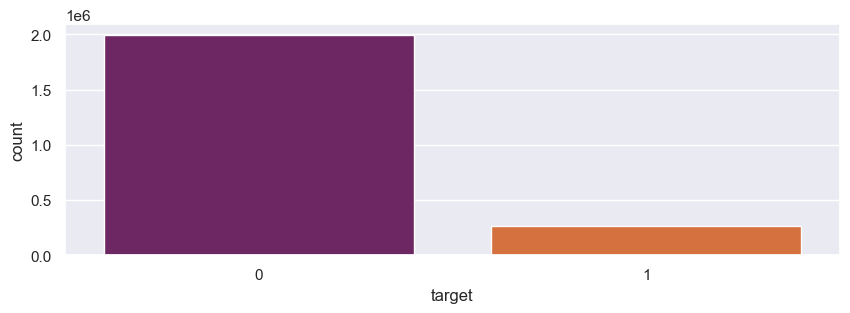

In [13]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,3)})
sns.countplot(x='target', data=accepted_loans, palette='inferno')


## Split Dataset

In [94]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    accepted_loans[categorical_cols + float_cols], accepted_loans.target, random_state=42, stratify=accepted_loans.target)

In [15]:
assert(len(data_train.columns.to_list())) == 64
assert(len(data_test.columns.to_list())) == 64

In [16]:
target_train.value_counts()

0    1494393
1     201132
Name: target, dtype: int64

## Pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [18]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['loan_amnt', 'int_rate', 'installment',
                                  'grade', 'sub_grade', 'emp_length',
                                  'annual_inc', 'dti', 'delinq_2yrs',
                                  'inq_last_6mths', 'open_acc', 'pub_rec',
                                  'revol_bal', 'revol_util', 'total_acc',
                                  'collections_12_mths_ex_med',
                                  'acc_now_del...
                                  'delinq_amnt', 'mo_sin_old_il_acct',
                                  'mo_sin_old_rev_tl_op',
                                  'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
                                  'mort_acc', 'mths_since_recent_bc', ...]),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['term', 'home_ownership',
                                  'verification_status', 'pymnt_plan',
                                  'purpose', 'initial_list_status',
                                  'application_type', 'emp_title_cat',
                                  'categorized_states'])])

### Dummy Classifier

In [19]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(data_train, target_train)
print(f"Accuracy of the dummy classifier: "
      f"{dummy_classifier.score(data_test, target_test):.3f}")

Accuracy of the dummy classifier: 0.881


### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

logistic_model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
logistic_model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'grade',
                                                   'sub_grade', 'emp_length',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'revol_util', 'total_acc',
                                                   'col...
                                                   'mo_sin_rcnt_rev_tl_op',
                                                   'mo_sin_rcnt_tl', 'mort_acc',
                                                   'mths_since_recent_bc', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'initial_list_status',
                                                   'application_type',
                                                   'emp_title_cat',
                                                   'categorized_states'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [95]:
_ = logistic_model.fit(data_train, target_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
logistic_model.score(data_test, target_test)

0.8797896584426798

Confusion matrix, without normalization
[[495204   2505]
 [ 65435   2032]]


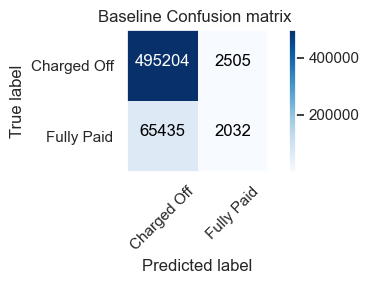

In [23]:
# Compute confusion matrix
cnf_matrix= confusion_matrix(target_test, logistic_model.predict(data_test))
class_names = ['Charged Off', "Fully Paid"]
np.set_printoptions(precision=2)

# Plot hold out set confusion matrix
plt.figure(figsize = (5,3))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Baseline Confusion matrix ')

Text(0.5, 1.0, 'ROC curve')

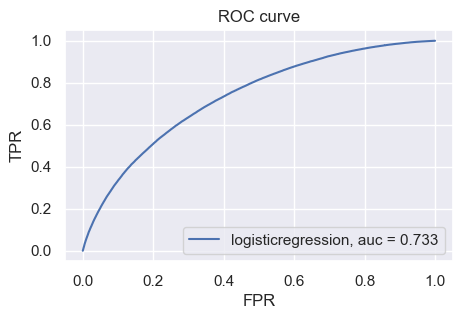

In [24]:
# Plotting ROC curves 
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

name = logistic_model.steps[1][0]
model_probs = logistic_model.predict_proba(data_test)[:, 1:]
model_auc_score = roc_auc_score(target_test, model_probs)
fpr, tpr, _ = roc_curve(target_test, model_probs)
axes.plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    
axes.legend(loc="lower right")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.set_title("ROC curve")

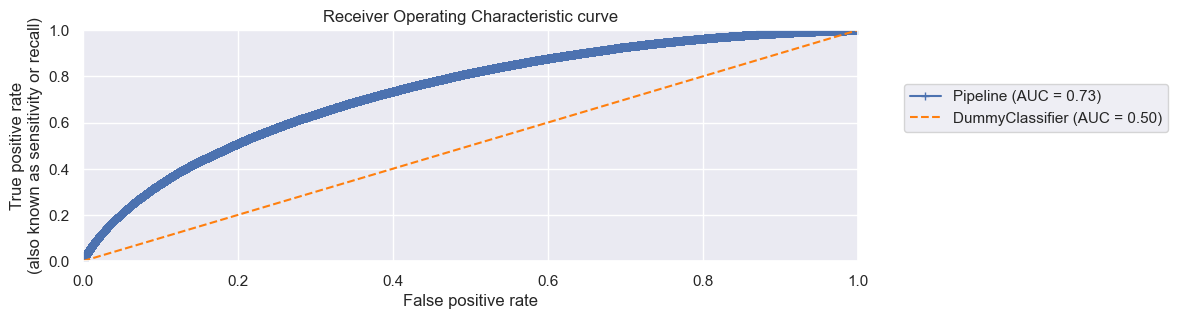

In [25]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(
    logistic_model, data_test, target_test, pos_label=1,
    marker="+")
disp = RocCurveDisplay.from_estimator(
    dummy_classifier, data_test, target_test, pos_label=1,
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate\n(also known as sensitivity or recall)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Receiver Operating Characteristic curve")

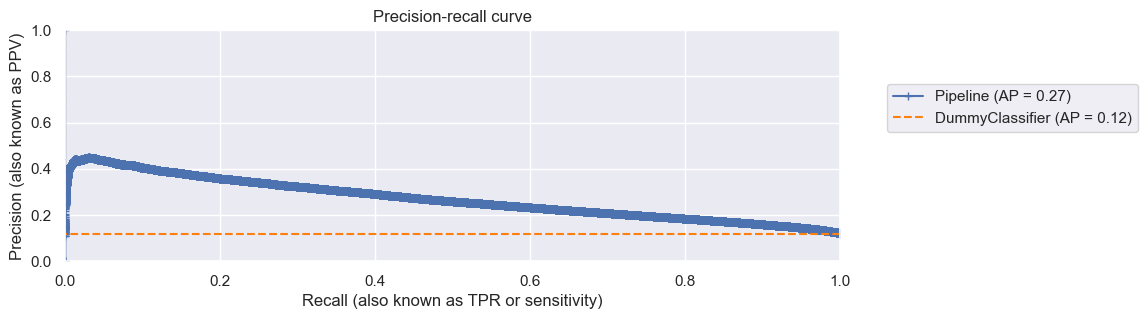

In [26]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(
    logistic_model, data_test, target_test, pos_label=1,
    marker="+"
)
disp = PrecisionRecallDisplay.from_estimator(
    dummy_classifier, data_test, target_test, pos_label=1,
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.xlabel("Recall (also known as TPR or sensitivity)")
plt.ylabel("Precision (also known as PPV)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Precision-recall curve")

## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=42, n_jobs=2)
)


In [81]:
_ = random_forest_model.fit(data_train, target_train)

In [82]:
random_forest_model.score(data_test, target_test)

0.8806654918114003

In [85]:
probs_random_forest = random_forest_model.predict_proba(data_test)[:, 1:]

<AxesSubplot: ylabel='Density'>

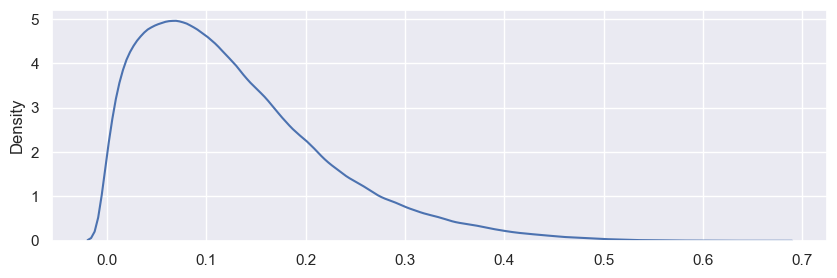

In [86]:
sns.kdeplot(np.ravel(probs_random_forest[:]), label='Random Forest')

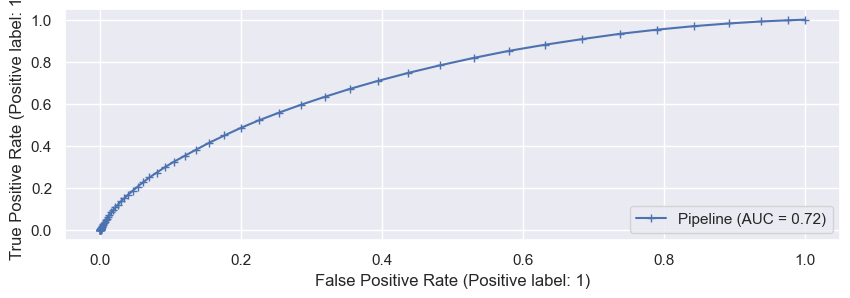

In [89]:
disp = RocCurveDisplay.from_estimator(
    random_forest_model, data_test, target_test, pos_label=1,
    marker="+")

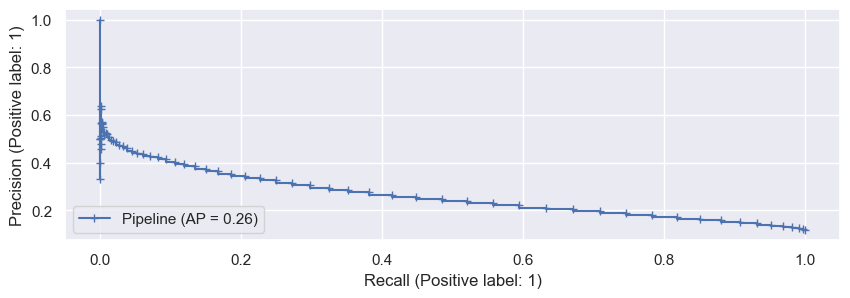

In [90]:
disp = PrecisionRecallDisplay.from_estimator(
    random_forest_model, data_test, target_test, pos_label=1,
    marker="+"
)

#### Balancing

In [91]:
random_forest_model.set_params(randomforestclassifier__class_weight="balanced")

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'grade',
                                                   'sub_grade', 'emp_length',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_bal',
                                                   'revol_util', 'total_acc',
                                                   'col...
                                                   'mths_since_recent_bc', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'home_ownership',
                                                   'verification_status',
                                                   'pymnt_plan', 'purpose',
                                                   'initial_list_status',
                                                   'application_type',
                                                   'emp_title_cat',
                                                   'categorized_states'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=2,
                                        random_state=42))])

In [92]:
_ = random_forest_model.fit(data_train, target_train)

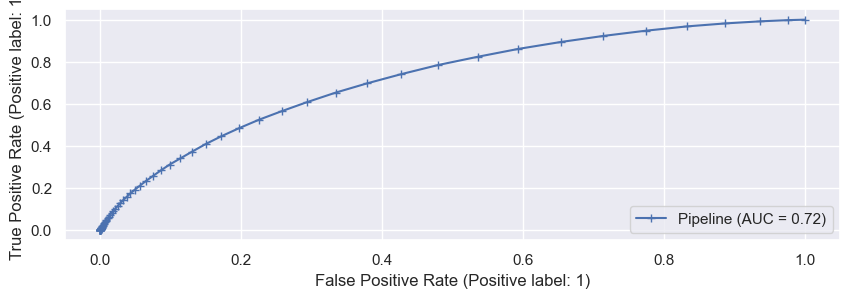

In [93]:
disp = RocCurveDisplay.from_estimator(
    random_forest_model, data_test, target_test, pos_label=1,
    marker="+")

### LightGBM

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

# categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
#                                           unknown_value=-1)

# preprocessor = ColumnTransformer([
#     ('categorical', categorical_preprocessor, categorical_cols)],
#     remainder="passthrough")

lightgbm_model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [28]:
_ = lightgbm_model.fit(data_train, target_train)

In [29]:
lightgbm_model.score(data_test, target_test)


0.8809379733038912

Text(0.5, 1.0, 'ROC curve')

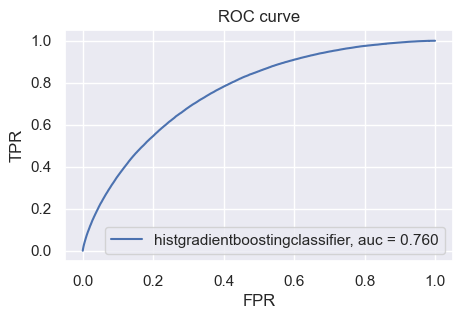

In [30]:
# Plotting ROC curves 
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

name = lightgbm_model.steps[1][0]
model_probs = lightgbm_model.predict_proba(data_test)[:, 1:]
model_auc_score = roc_auc_score(target_test, model_probs)
fpr, tpr, _ = roc_curve(target_test, model_probs)
axes.plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    
axes.legend(loc="lower right")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.set_title("ROC curve")

In [31]:
lightgbm_model.classes_.tolist()

[0, 1]

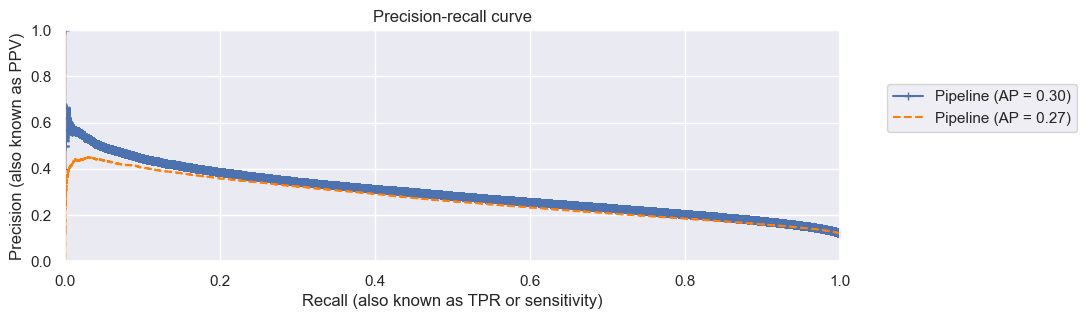

In [32]:
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay.from_estimator(
    lightgbm_model, data_test, target_test, pos_label=1,
    marker="+"
)
disp = PrecisionRecallDisplay.from_estimator(
    logistic_model, data_test, target_test, pos_label=1,
    color="tab:orange", linestyle="--", ax=disp.ax_)
plt.xlabel("Recall (also known as TPR or sensitivity)")
plt.ylabel("Precision (also known as PPV)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = disp.ax_.set_title("Precision-recall curve")

## Class Imbalance

def classification_model(model, param_grid, score = 'roc_auc'):
    
    # setting the number of folds
    kf = KFold(10)
    
    # Instantiate the GridSearchCV object: cv
    model_cv = GridSearchCV(model, param_grid, cv = kf, scoring = score, 
                            return_train_score = True, n_jobs = -3)
    
    # Fitting the training set 
    model_cv.fit(data_train, target_train)
        
    # Predict the labels of the test set: y_pred        
    y_pred = model_cv.predict_proba(data_test)[:, 1:]
    
    # Printing best parametrs
    print("Tuned Model Parameters: {}".format(model_cv.best_params_))
    
     # Printing the corresponding AUROC "
    test_roc = roc_auc_score(data_test, y_pred)
    print('The hold-out set AUROC = ' + str(test_roc))
    
    # Compute confusion matrix
    cnf_matrix= confusion_matrix(target_test, model_cv.predict(data_test))
    class_names = ['Charged Off', "Fully Paid"]
    np.set_printoptions(precision=2)

    # Plot hold out set confusion matrix
    plt.figure(figsize = (9,7))
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Hold-out set Confusion matrix ')
    
    return pd.DataFrame(model_cv.cv_results_)

In [ ]:
# c _space
c_space =[0.01, 0.1, 0.3, 1, 3, 10, 30, 100, 300]

# parameters for grid search 
param_grid = {'C': c_space, 'class_weight':[{0:6, 1:1}, 'balanced', {0:7,1:1}, {0:8,1:1}]}

# calculating results
%time results = classification_model(logistic_model.named_steps['logisticregression'], param_grid) 

## Calibration

In [ ]:
# from sklearn.svm import SVC
# svc_model = make_pipeline(preprocessor, SVC())
# _ = svc_model.fit(data_train, target_train)

In [107]:
probs_lgr = logistic_model.predict_proba(data_test)[:]
probs_lightgbm = lightgbm_model.predict_proba(data_test)[:]
probs_random_forest = random_forest_model.predict_proba(data_test)[:]


<AxesSubplot: ylabel='Count'>

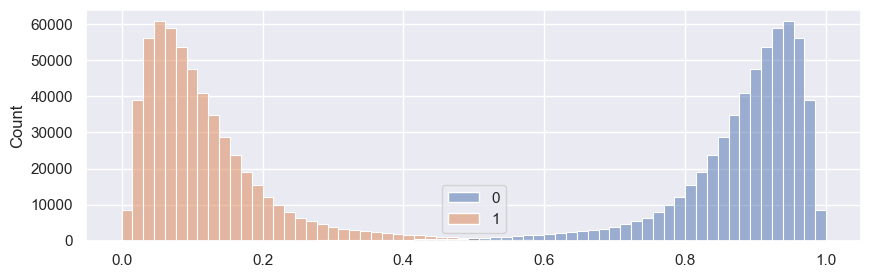

In [104]:
sns.histplot(probs_lgr)

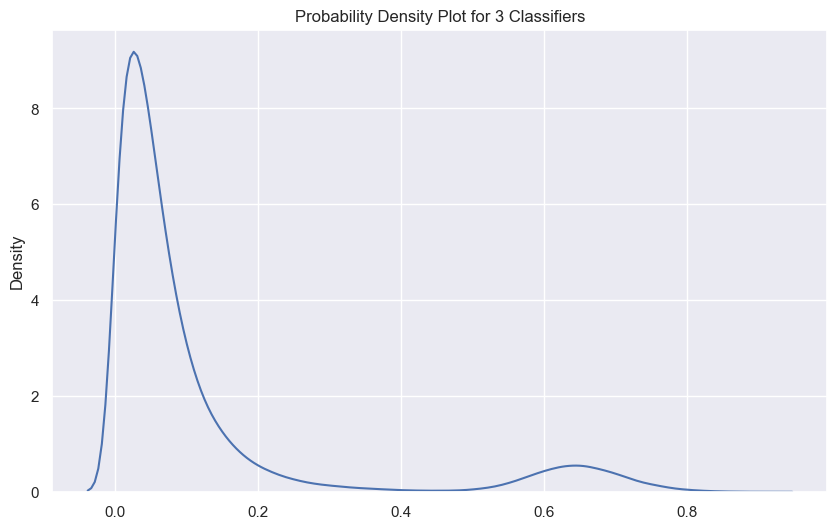

In [121]:
plt.figure(figsize=(10,6))
# sns.kdeplot(np.ravel(probs_lgr[:,1]), label='Logistic regression')
# sns.kdeplot(np.ravel(probs_lightgbm[:,1]), label='Light GBM')
sns.kdeplot(np.ravel(probs_random_forest[:,1]), label='Random Forest')
plt.title("Probability Density Plot for 3 Classifiers")
plt.show()

In [124]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(target_test, probs, n_bins=50, pos_label=1)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=50, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [113]:
probs_lgr[:,1]

array([0.2 , 0.09, 0.21, ..., 0.18, 0.07, 0.03])

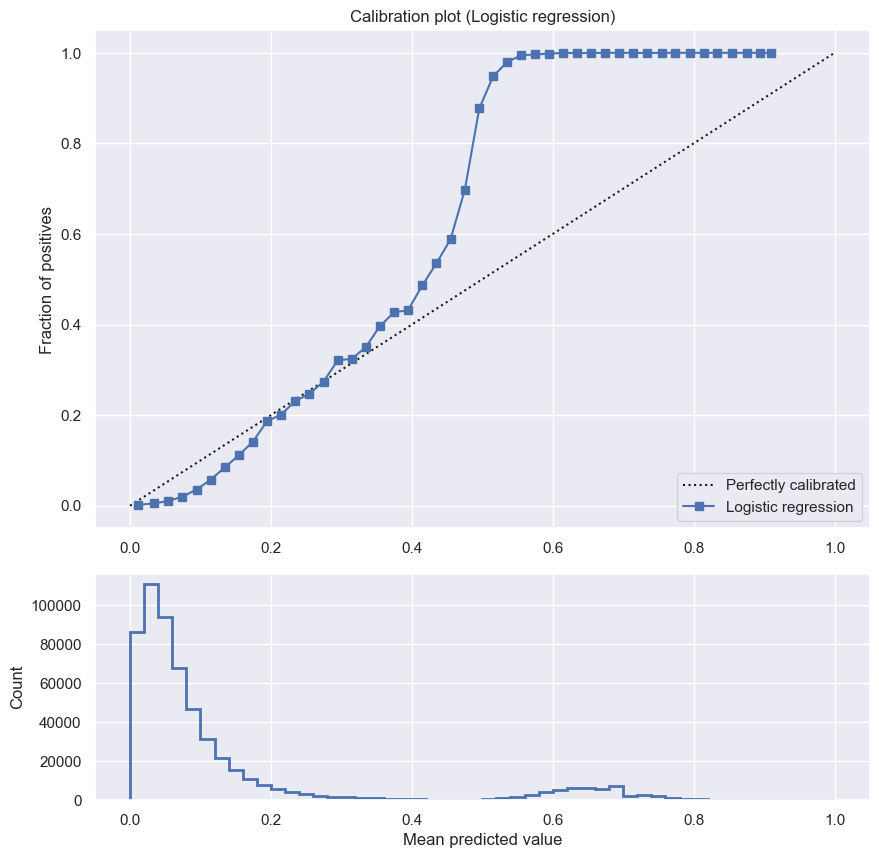

In [125]:
plot_calibration_curve("Logistic regression", 1, probs_random_forest[:,1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


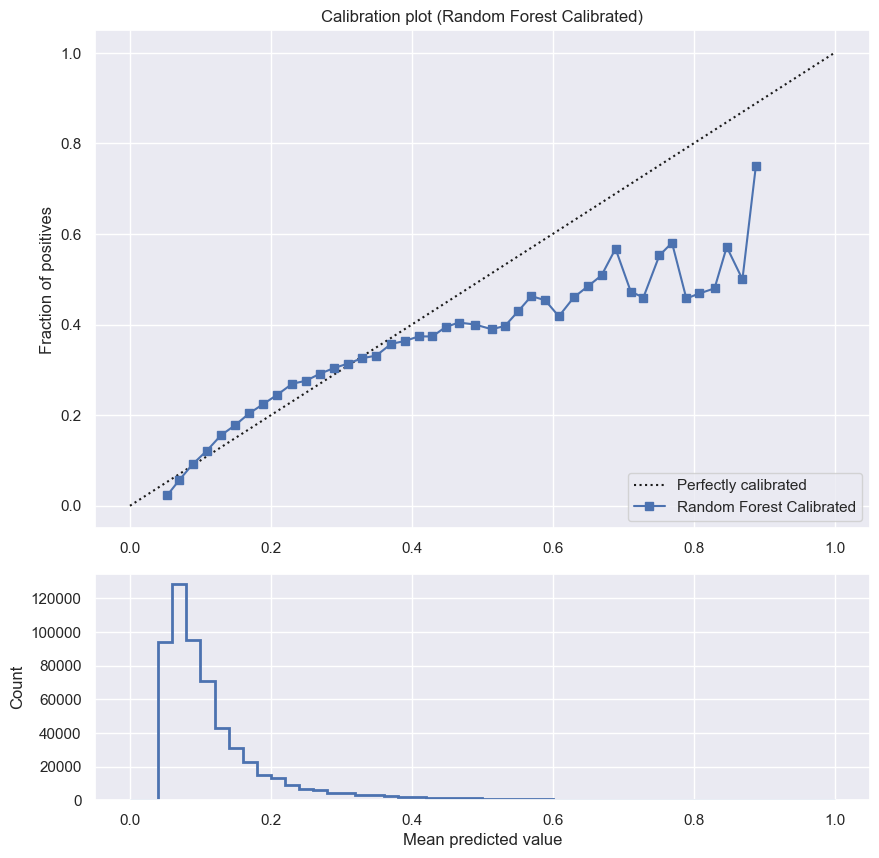

In [126]:
from sklearn.calibration import CalibratedClassifierCV


lgr = LogisticRegression(C=1, solver='lbfgs')

platts_scaling = CalibratedClassifierCV(random_forest_model, cv=2, method='sigmoid')
platts_scaling.fit(data_train, target_train)
calibrated_probs = platts_scaling.predict_proba(data_test)[:,1]

plot_calibration_curve("Random Forest Calibrated", 3, calibrated_probs)

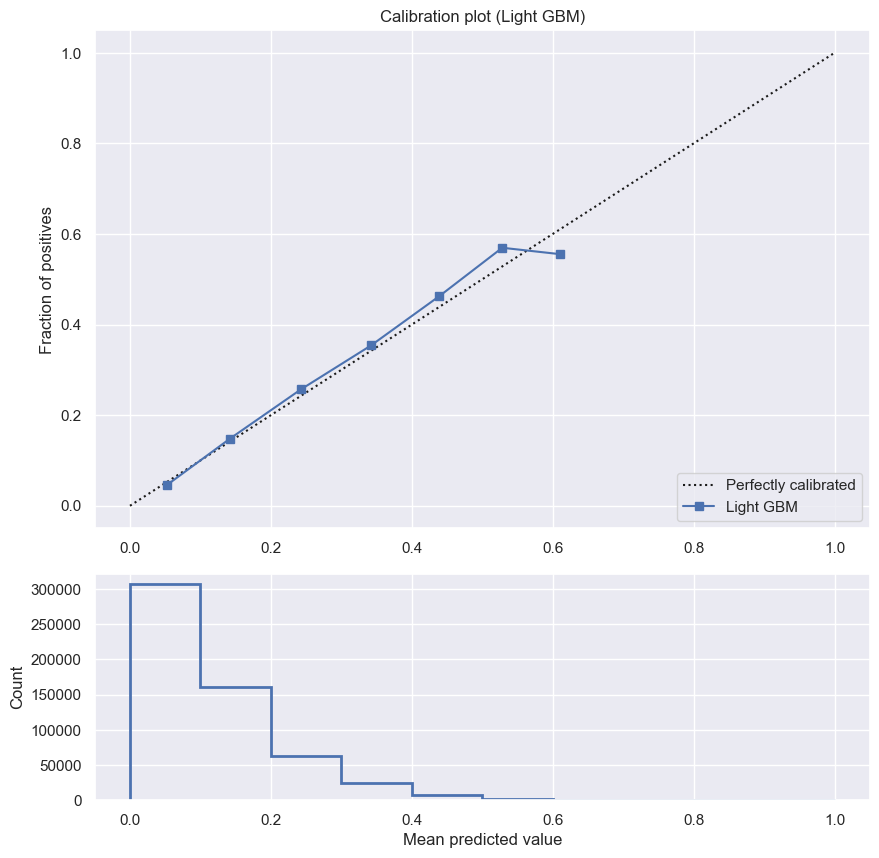

In [74]:
plot_calibration_curve("Light GBM", 1, probs_lightgbm)